# OpenAPI를 활용한 한국어 분석

## 필요 패키지 설치

In [1]:
!pip install dataclasses dataclasses_json

In [2]:
!pip install urllib3

In [3]:
!pip install wordcloud

In [4]:
!pip install matplotlib

## 공통 모듈 임포트

In [5]:
import json
from pathlib import Path

## OpenAPI 설정, 정의, 테스트

In [6]:
# API 인증키 설정 (사전준비를 통해 획득한 인증키로 변경하기 바람)
my_access_key = "8541da0b-c49c-47ce-9652-aaad6c580997"

In [7]:
# API 호출 함수 정의
import urllib3

def analyze_by_openapi(text: str,
                       key: str,
                       url: str = "http://aiopen.etri.re.kr:8000/WiseNLU"):
    req = {
        "argument": {
            "analysis_code": "ner",
            "text": text,
        }
    }
    http = urllib3.PoolManager()
    res = http.request(
        method="POST",
        url=url,
        headers={"Content-Type": "application/json; charset=UTF-8", "Authorization": key},
        body=json.dumps(req)
    )
    return res

In [8]:
# 단순 텍스트 분석
response = analyze_by_openapi(text="대한민국은 동아시아의 한반도 군사 분계선 남부에 위치한 국가이다.", key=my_access_key)
response_code = response.status
response_data = response.data.decode("utf-8")

In [9]:
response_code

200

In [10]:
response_data

'{"result":0,"return_object":{"doc_id":"","DCT":"","category":"","category_weight":0,"title":{"text":"","NE":""},"metaInfo":{},"paragraphInfo":[],"sentence":[{"id":0,"reserve_str":"","text":"대한민국은 동아시아의 한반도 군사 분계선 남부에 위치한 국가이다.","morp":[{"id":0,"lemma":"대한민국","type":"NNP","position":0,"weight":0.144641},{"id":1,"lemma":"은","type":"JX","position":12,"weight":0.125928},{"id":2,"lemma":"동아시아","type":"NNP","position":16,"weight":0.153205},{"id":3,"lemma":"의","type":"JKG","position":28,"weight":0.171225},{"id":4,"lemma":"한반도","type":"NNP","position":32,"weight":1},{"id":5,"lemma":"군사","type":"NNG","position":42,"weight":0.180792},{"id":6,"lemma":"분계","type":"NNG","position":49,"weight":0.0509049},{"id":7,"lemma":"선","type":"XSN","position":55,"weight":0.0509049},{"id":8,"lemma":"남부","type":"NNG","position":59,"weight":0.0952029},{"id":9,"lemma":"에","type":"JKB","position":65,"weight":0.0982995},{"id":10,"lemma":"위치","type":"NNG","position":69,"weight":0.122576},{"id":11,"lemma":"하","type":"

In [11]:
# 응답 문자열 -> JSON -> 파일 저장
object_origin = json.loads(response_data)
json_origin = json.dumps(object_origin, ensure_ascii=False, indent=4)
Path("out").mkdir(exist_ok=True)
Path("out/origin.json").write_text(json_origin)

15736

In [12]:
# 파일 내용 확인
!cat out/origin.json

{
    "result": 0,
    "return_object": {
        "doc_id": "",
        "DCT": "",
        "category": "",
        "category_weight": 0,
        "title": {
            "text": "",
            "NE": ""
        },
        "metaInfo": {},
        "paragraphInfo": [],
        "sentence": [
            {
                "id": 0,
                "reserve_str": "",
                "text": "대한민국은 동아시아의 한반도 군사 분계선 남부에 위치한 국가이다.",
                "morp": [
                    {
                        "id": 0,
                        "lemma": "대한민국",
                        "type": "NNP",
                        "position": 0,
                        "weight": 0.144641
                    },
                    {
                        "id": 1,
                        "lemma": "은",
                        "type": "JX",
                        "position": 12,
                        "weight": 0.125928
                    },
                    {
                        "id": 2,
                 

## 필요 데이터클래스 정의

In [13]:
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin

# 형태소(Morp)
@dataclass
class Morp(DataClassJsonMixin):
    id: int
    lemma: str
    type: str
    position: int

# 어휘의미(WSD)
@dataclass
class WSD(DataClassJsonMixin):
    id: int
    text: str
    type: str
    scode: str
    begin: int
    end: int

# 개체명(NE)
@dataclass
class NE(DataClassJsonMixin):
    id: int
    text: str
    type: str
    begin: int
    end: int

# 어절(Word)
@dataclass
class Word(DataClassJsonMixin):
    id: int
    text: str
    begin: int
    end: int

# 문장(Sentence)
@dataclass
class Sentence(DataClassJsonMixin):
    id: int
    text: str
    word: list[Word]
    morp: list[Morp]
    WSD: list[WSD]
    NE: list[NE]

# 문서(Document)
@dataclass
class Document(DataClassJsonMixin):
    doc_id: str
    sentence: list[Sentence]

# API 응답(Response)
@dataclass
class Response(DataClassJsonMixin):
    result: int
    reason: str | None = None
    return_object: Document | None = None

In [14]:
# 파일 로드 -> JSON -> 데이터클래스(객체)
json_read = Path("out/origin.json").read_text()
custom = Response.from_json(json_read)
json_custom = custom.to_json(indent=4, ensure_ascii=False)

In [15]:
# JSON 문자열 비교
print("json_read == json_origin:", json_read == json_origin)
print("json_custom == json_origin:", json_custom == json_origin)
print("len(json_origin):", len(json_origin))
print("len(json_custom):", len(json_custom))

json_read == json_origin: True
json_custom == json_origin: False
len(json_origin): 15736
len(json_custom): 10347


In [16]:
# 데이터클래스(객체) -> JSON -> 파일 저장
Path("out").mkdir(exist_ok=True)
Path("out/custom.json").write_text(json_custom)

10347

In [17]:
# 파일 내용 확인
!cat out/custom.json

{
    "result": 0,
    "reason": null,
    "return_object": {
        "doc_id": "",
        "sentence": [
            {
                "id": 0,
                "text": "대한민국은 동아시아의 한반도 군사 분계선 남부에 위치한 국가이다.",
                "word": [
                    {
                        "id": 0,
                        "text": "대한민국은",
                        "begin": 0,
                        "end": 1
                    },
                    {
                        "id": 1,
                        "text": "동아시아의",
                        "begin": 2,
                        "end": 3
                    },
                    {
                        "id": 2,
                        "text": "한반도",
                        "begin": 4,
                        "end": 4
                    },
                    {
                        "id": 3,
                        "text": "군사",
                        "begin": 5,
                        "end": 5
                    },
                  

## 파일 목록 확인

In [18]:
# 파일 목록 조회 함수 정의
def list_files(path: str, ext: str = "*") -> list[Path]:
    return sorted(Path(path).glob(f"*.{ext}"))

In [19]:
# 파일 목록 출력 테스트
print("* Data files:")
for file in list_files("data"):
    print("  + " + str(file))

* Data files:
  + data/01.txt
  + data/02.txt
  + data/03.txt
  + data/04.txt
  + data/05.txt
  + data/06.txt
  + data/07.txt


## 뉴스 집합 분석

In [20]:
# 형태소 태그 관련 정의
noun_tags = ("NNP", "NNG", "SL")  # 명사 태그 정의
verb_tabs = ("VV", "VA")  # 동사 태그 정의

# 개체명 변환 함수
def upper_ne_type(x: str) -> str:
    return x.split('_')[0]

In [21]:
# 카운터 초기화
from collections import Counter
noun_freqs = Counter()
verb_freqs = Counter()
ne_freqs = Counter()

In [22]:
# 파일별 분석하기 수행
print("* Data files:")
for file in list_files("data"):
    # 파일명 출력
    print("  + " + str(file))
    # 파일 내용을 OpenAPI로 분석
    res = analyze_by_openapi(text=file.read_text(), key=my_access_key)
    obj = Response.from_json(res.data.decode("utf-8"))
    # 분석 결과 처리
    if obj.return_object is not None:
        doc: Document = obj.return_object
        # 문장별 처리
        for sentence in doc.sentence:
            # 문장 텍스트 출력
            print("    - " + sentence.text.strip())
            # 어휘의미(WSD) 단위별 처리
            for wsd in sentence.WSD:
                if wsd.type in noun_tags:  # 명사
                    noun_freqs[wsd.text] += 1
                elif wsd.type in verb_tabs:  # 동사
                    verb_freqs[wsd.text + "다"] += 1
            # 개체명(NE) 단위별 처리
            for ne in sentence.NE:
                ne_freqs[f"{ne.text}/{upper_ne_type(ne.type)}"] += 1

* Data files:
  + data/01.txt
    - [체험기] 가벼워진 아이폰15 프로맥스, 카메라·동작버튼 훌륭하지만…
    - 손난로 ‘발열’은 여전
    - 아이폰15 프로맥스(왼쪽·6.7인치)와 아이폰15 프로(오른쪽·6.1인치).
    - 더 얇아진 베젤과 측면 티타늄 소재로 그립감이 크게 개선됐다.
    - /윤진우 기자
    - 애플 아이폰 만큼 평가가 엇갈리는 스마트폰도 없을 것이다.
    - 오래 봐도 질리지 않는 ‘깔끔한 디자인’, 2년을 써도 느려지지 않는 ‘최적화 성능’, 되팔 때 기분 좋은 ‘중고 가격 방어’가 아이폰의 독보적인 장점으로 꼽힌다.
    - 반면 자세히 봐야 차이를 알 수 있는 ‘사골(계속 우려먹는다는 의미) 디자인’, 통화 녹음 부재 등 ‘불편한 사용 환경’은 아이폰의 단점이다.
    - 그럼에도 아이폰은 독보적인 팬덤을 형성하면서 승승장구하고 있다.
    - 미래 소비층으로 떠오르는 10대와 20대 사이에서 아이폰의 인기는 상상을 초월한다.
    - 미국 10대 소비자의 87%가 아이폰을 사용하고 있으며, 국내 아이폰15 시리즈 사전 예약참여자의 절반이 20대인 건 이런 현상을 명확하게 보여준다.
    - 비싸고 불편하며, 문제가 있다는 비판에도 아이폰을 향한 젊은 층의 관심은 식을 줄 모른다는 의미다.
    - 애플이 지난 13일 국내에 출시한 아이폰15 프로맥스는 장점이 뚜렷한 제품이다.
    - 외부 디자인은 눈으로만 보면 전작인 아이폰14 프로맥스와 차이를 찾을 수 없지만 직접 만져보면 전혀 다른 제품으로 느껴진다.
    - 아이폰15 프로맥스의 화면 크기는 6.7인치로 아이폰14 프로맥스와 같다.
    - 하지만 세로와 가로 크기가 각각 1㎜씩 줄어 한 손에 들어오는 그립감이 크게 개선됐다.
    - 모서리를 둥글게 처리한 마감은 더 부드러운 그립감을 느끼게 한다.
    - 아이폰15 프로맥스에서 동작 버튼으로 설정할 수 있는 무음 모드, 카메라, 단축어, 음성 메모,

In [23]:
# 고빈도 명사 출력
noun_freqs.most_common(50)

[('AI', 67),
 ('아이폰', 30),
 ('LLM', 22),
 ('슈퍼컴', 22),
 ('글로벌', 20),
 ('프로맥스', 19),
 ('통신사', 17),
 ('SKT', 16),
 ('거대', 14),
 ('개발', 14),
 ('디즈니', 12),
 ('개인', 12),
 ('KT', 12),
 ('구축', 12),
 ('도이치텔레콤', 12),
 ('통신', 12),
 ('공동', 12),
 ('정보', 12),
 ('사업', 12),
 ('생성', 12),
 ('버튼', 11),
 ('성능', 11),
 ('시장', 11),
 ('모델', 11),
 ('카메라', 10),
 ('사진', 10),
 ('한국', 10),
 ('도입', 10),
 ('서비스', 10),
 ('최대', 9),
 ('무빙', 9),
 ('세계', 9),
 ('KISTI', 9),
 ('가격', 8),
 ('공유', 8),
 ('이번', 8),
 ('기술', 8),
 ('GPU', 8),
 ('동작', 7),
 ('배터리', 7),
 ('최근', 7),
 ('상황', 7),
 ('양사', 7),
 ('사향', 7),
 ('관련', 7),
 ('급', 7),
 ('발열', 6),
 ('의미', 6),
 ('미국', 6),
 ('모드', 6)]

In [24]:
# 고빈도 동사 출력
verb_freqs.most_common(50)

[('있다', 29),
 ('하다', 15),
 ('지나다', 12),
 ('크다', 10),
 ('같다', 10),
 ('통하다', 10),
 ('없다', 9),
 ('보다', 9),
 ('되다', 8),
 ('위하다', 8),
 ('개발하다', 8),
 ('낮추다', 7),
 ('사용하다', 6),
 ('새롭다', 6),
 ('설정하다', 5),
 ('활용하다', 5),
 ('밝히다', 5),
 ('따르다', 5),
 ('기대하다', 5),
 ('마련하다', 5),
 ('쓰다', 4),
 ('보이다', 4),
 ('느끼다', 4),
 ('선명하다', 4),
 ('찍다', 4),
 ('공유하다', 4),
 ('도입하다', 4),
 ('떨어지다', 4),
 ('확보하다', 4),
 ('가볍다', 3),
 ('오다', 3),
 ('원하다', 3),
 ('말하다', 3),
 ('누르다', 3),
 ('다양하다', 3),
 ('시청하다', 3),
 ('심하다', 3),
 ('나오다', 3),
 ('시행하다', 3),
 ('대하다', 3),
 ('받다', 3),
 ('서명하다', 3),
 ('공개하다', 3),
 ('맞추다', 3),
 ('체결하다', 3),
 ('열리다', 3),
 ('분석하다', 3),
 ('늘어나다', 3),
 ('가벼워지다', 2),
 ('개선되다', 2)]

In [25]:
# 고빈도 개체명 출력
ne_freqs.most_common(50)

[('SKT/OGG', 16),
 ('아이폰15/TMI', 15),
 ('KT/OGG', 12),
 ('도이치텔레콤/OGG', 12),
 ('아이폰/TMI', 11),
 ('프로맥스/OGG', 11),
 ('양사/QT', 11),
 ('카메라/TMI', 10),
 ('한국/LCP', 10),
 ('6호기/QT', 10),
 ('KISTI/OGG', 9),
 ('디즈니+/OGG', 8),
 ('슈퍼컴/OGG', 8),
 ('22일/DT', 6),
 ('대표/CV', 6),
 ('회장/CV', 6),
 ('서울/LCP', 6),
 ('GPU/TMI', 6),
 ('애플/OGG', 5),
 ('미국/LCP', 5),
 ('배터리/TMI', 5),
 ('태국어/CV', 5),
 ('AI/TMM', 5),
 ('태국/LCP', 5),
 ('교수/CV', 5),
 ('GPA/OGG', 5),
 ('발열/TMM', 4),
 ('디즈니/OGG', 4),
 ('넷플릭스/OGG', 4),
 ('이용자/CV', 4),
 ('영어/CV', 4),
 ('LLM/TMI', 4),
 ('자스민그룹/OGG', 4),
 ('유영상/PS', 4),
 ('지난 20일/DT', 4),
 ('ITU-T/OGG', 4),
 ('2025년/DT', 4),
 ('15 프로맥스/QT', 3),
 ('프로/CV', 3),
 ('오른쪽/TM', 3),
 ('20대/QT', 3),
 ('아이폰14/TMI', 3),
 ('프로맥스/TMI', 3),
 ('일주일간/DT', 3),
 ('유튜브/OGG', 3),
 ('SK텔레콤/OGG', 3),
 ('동남아시아/LCG', 3),
 ('LLM/TR', 3),
 ('동남아/LCG', 3),
 ('중국/LCP', 3)]

## 워드클라우드를 통한 시각화

In [26]:
# 워드클라우드 생성 함수 정의
from wordcloud import WordCloud

def make_wordcloud(cnt: Counter,
                   background_color="white",
                   font_path="font/NanumSquareB.ttf",
                   max_font_size=240,
                   width=800, height=600):
    wc = WordCloud(background_color=background_color,
                   font_path=font_path,
                   max_font_size=max_font_size,
                   width=width, height=height)
    wc.generate_from_frequencies(dict(cnt))
    return wc

In [27]:
# 워드클라우드 생성
Path("out").mkdir(exist_ok=True)
noun_wc = make_wordcloud(noun_freqs)
verb_wc = make_wordcloud(verb_freqs)
ne_wc = make_wordcloud(ne_freqs)

In [28]:
# 워드클라우드 변환 함수 정의
import matplotlib.pyplot as plt

def wordcloud_to_figure(wc: WordCloud, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(wc)

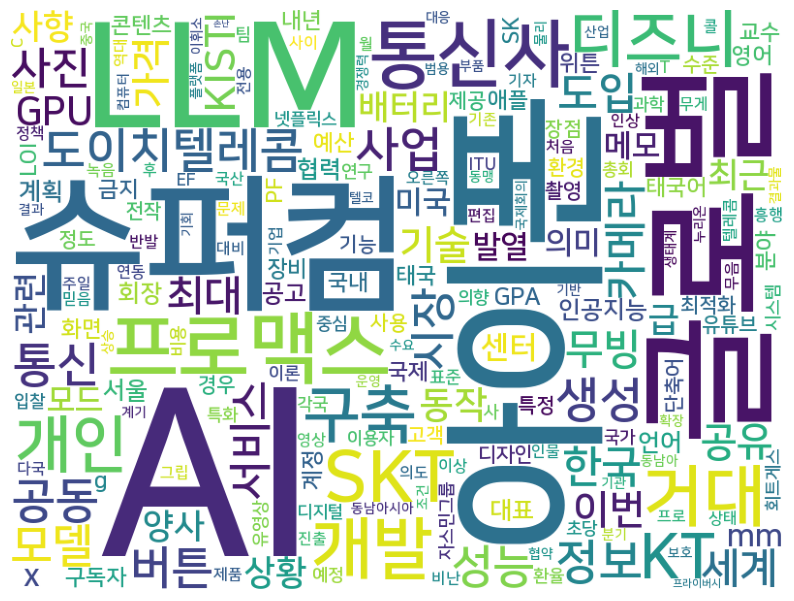

In [29]:
# 워드클라우드: 명사
wordcloud_to_figure(noun_wc)

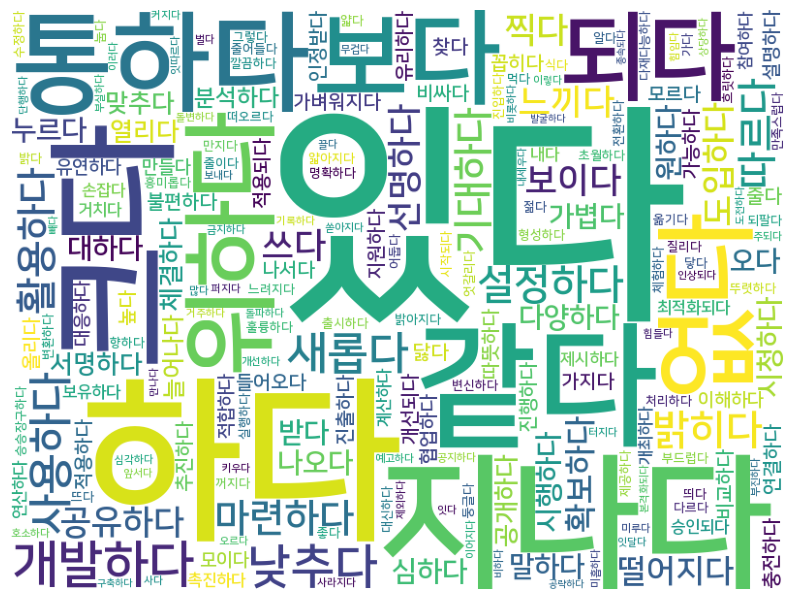

In [30]:
# 워드클라우드: 동사
wordcloud_to_figure(verb_wc)

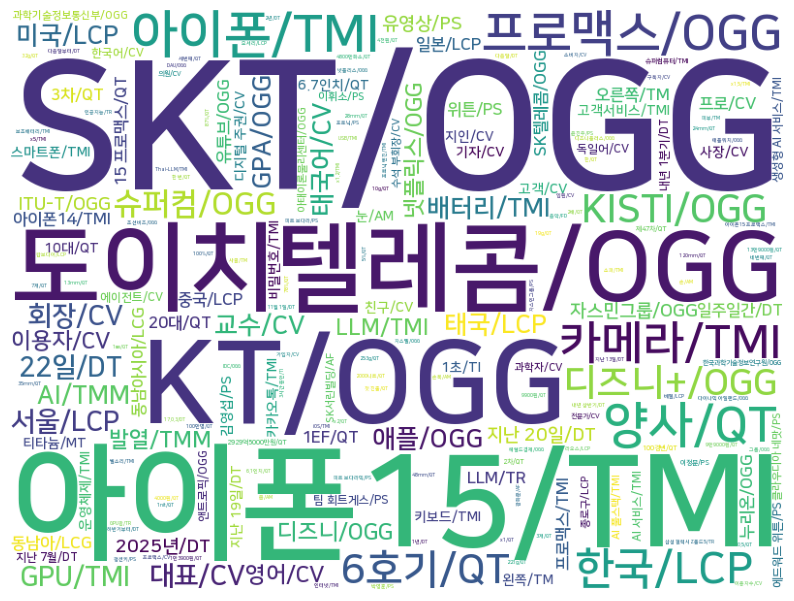

In [31]:
# 워드클라우드: 개체명
wordcloud_to_figure(ne_wc)